### Hello all who are interested in Deep Learning! I am happy to see you here!
Today I will write about my experience with Convolutional Neural Networks! I will describe here how to get image description. The image description will be consist of two parts. First one is summary about objects in the image, that are all classes that ConvNet found with given probability and number of objects per each class. Second part is type of activity in the image. First part of image description may be solved by detection task. I will use for it SSD algorithm. Second is classification task. For this task I will have to train CNN using pretrained model from ImageNet and apply transfer learning techique. Caffe framework will help me with all tasks.

### Let's start!

### First step is importing all libraries and setting up necessary version of Caffe.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)
plt.rcParams.update({'font.size': 22})


caffe_root = '/home/veronika/materials/cv/detection/caffe/examples/'  
sys.path.append('/home/veronika/materials/cv/detection/caffe/python')
sys.path.remove('/home/veronika/caffe/python')

import caffe

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### It is very important to mention here, don't forget to install caffe from the git. And check do you import correct version of caffe framework.

In [2]:
caffe.__file__

'/home/veronika/materials/cv/detection/caffe/python/caffe/__init__.pyc'

In [3]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2


labelmap_file = '/home/veronika/materials/cv/detection/git/labelmap_voc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

### The labelmap_voc.prototxt consist of number of label and corresponed name.

In [4]:
def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

In [5]:
labelmap.item[2].label

2

In [6]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [7]:
model_def = '/home/veronika/materials/cv/detection/models_trained/VGGNet/deploy.prototxt'
model_weights = '/home/veronika/materials/cv/detection/models_trained/VGGNet/VGG_VOC0712_SSD_300x300_iter_60000.caffemodel'

In [8]:
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)


### We have to transform input image in special way for Caffe.

In [9]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

In [10]:
image_resize = 300
net.blobs['data'].reshape(1,3,image_resize,image_resize)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
image = caffe.io.load_image('/home/veronika/photos/UCU2016/144.jpg')

plt.imshow(image)

#The photo is taken from closing ceremony of Lviv Computer Science School with me and Program director 
#Yaroslav Prytula.
#Just for example!:)

In [11]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[...] = transformed_image

# Forward pass.
detections = net.forward()['detection_out']
detections.shape

(1, 1, 16, 7)

In order to get bboxes we use the following code.

In [12]:
# Parse the outputs.
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_labels = get_labelname(labelmap, top_label_indices)
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

### The result of object detection you may find at the end of the blog.
### The algorithm, that I used for object detection is SSD (Single Shot MultiBox Detector)
### All additional information you may find here https://github.com/weiliu89/caffe/tree/ssd

In [13]:
descr = dict((i,top_labels.count(i)) for i in set(top_labels))
descr

{u'person': 2}

### Creating a simple function for image description.

In [19]:
def get_description(descr):
    text_descr = str()
    for i in descr.keys():
        if descr[i] == 1:
            text_descr = text_descr + "There is" + " " + str(descr[i]) + " " + i + "." + " "
        else:
            if i == "person":
                text_descr = text_descr + "There are" + " " + str(descr[i]) + " " +"people" + "." + " "
            else:
                text_descr = text_descr + "There are" + " " + str(descr[i]) + " " + i + "s" + "." + " "
    return(text_descr)

### The following part is about getting class activities label, that I have got using transfer learning.
### A copuple of words about transfer learning. I got pretrained model for GoogLeNet topology and trained the model on MPII dataset. 
### You may download the dataset here http://human-pose.mpi-inf.mpg.de/
### I have increased learning rate in the last layer by a factor of 10 in comparison with learning rate in previous layers. The gradient descent optimization algorithm was Adam. 
### My learning rate policy was
##### base_lr: 0.0005
##### lr_policy: "step"
##### stepsize: 2000

### Moreover, I was able to get 95% accuracy on test set, that is 10% of whole dataset.

In [15]:
class_label = pd.read_csv("/home/veronika/materials/cv/detection/class_labels.csv", sep = " ", header = None)
class_label

0                      1
0    0        running/walking
1    1                  other
2    2              bicycling
3    3  conditioning_exercise
4    4                dancing
5    5    fishing_and_hunting
6    6        home_activities
7    7            home_repair
8    8        lawn_and_garden
9    9          music_playing
10  10             occupation
11  11                 sports
12  12       water_activities
13  13      winter_activities

In [16]:
image_resize = 224
net.blobs['data'].reshape(1,3,image_resize,image_resize)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))

googlenet_root = "/home/veronika/materials/cv/cv_organizer/googlenet/adam4/"
model_config = os.path.join(googlenet_root, 'deploy.prototxt')
model_weights = os.path.join(googlenet_root, 'snapshot/_iter_3600.caffemodel')
net_act = caffe.Net(model_config, model_weights, caffe.TEST)

transformed_image = transformer.preprocess('data', image)
net_act.blobs['data'].data[...] = transformed_image

detections = net_act.forward()['prob']

In [17]:
action_label = class_label.loc[class_label[0] == detections.argmax()]
action_label = str(np.array(action_label[1]))

In [20]:
action_label = get_description(descr) + "Class activities is" + " " + action_label

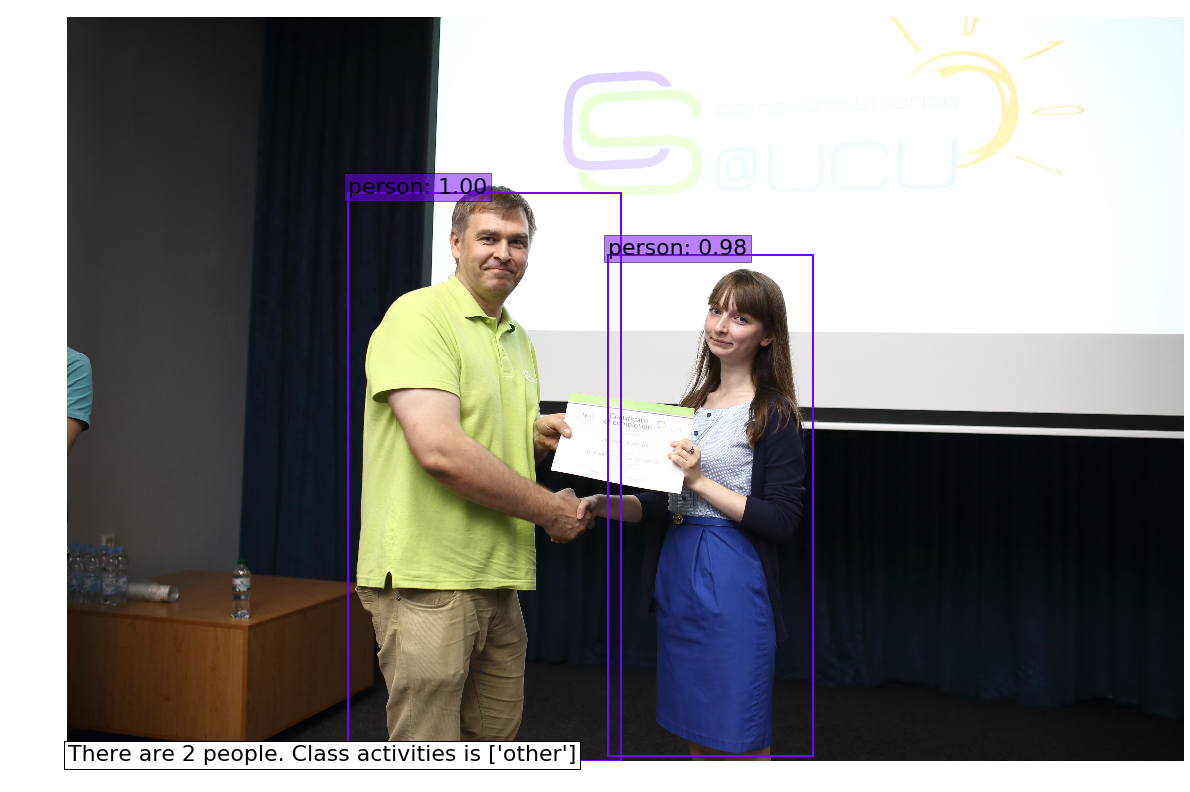

In [21]:
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.imshow(image)
currentAxis = plt.gca()
plt.axis('off')

for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = top_labels[i]
    display_txt = '%s: %.2f'%(label_name, score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    currentAxis.text(3, image.shape[0], action_label, bbox={'facecolor':"white"})
    #currentAxis.text(20, image.shape[0]-100, get_description(descr), bbox={'facecolor':"white"})

### In addition, I would like to add some photos from test set.

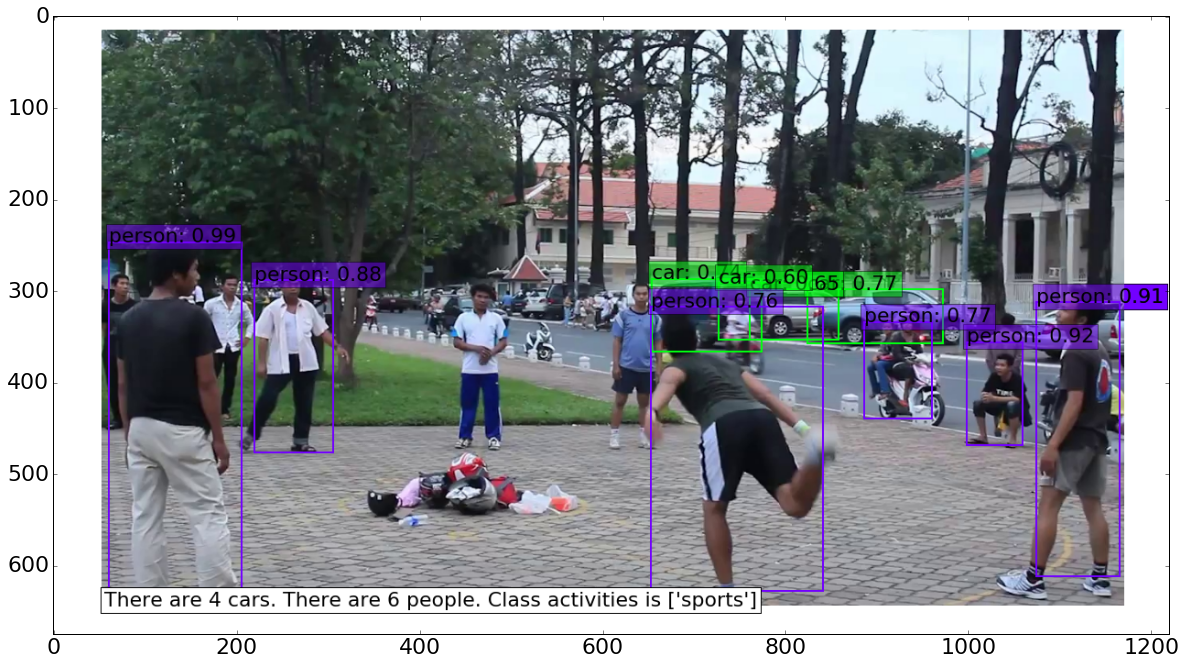

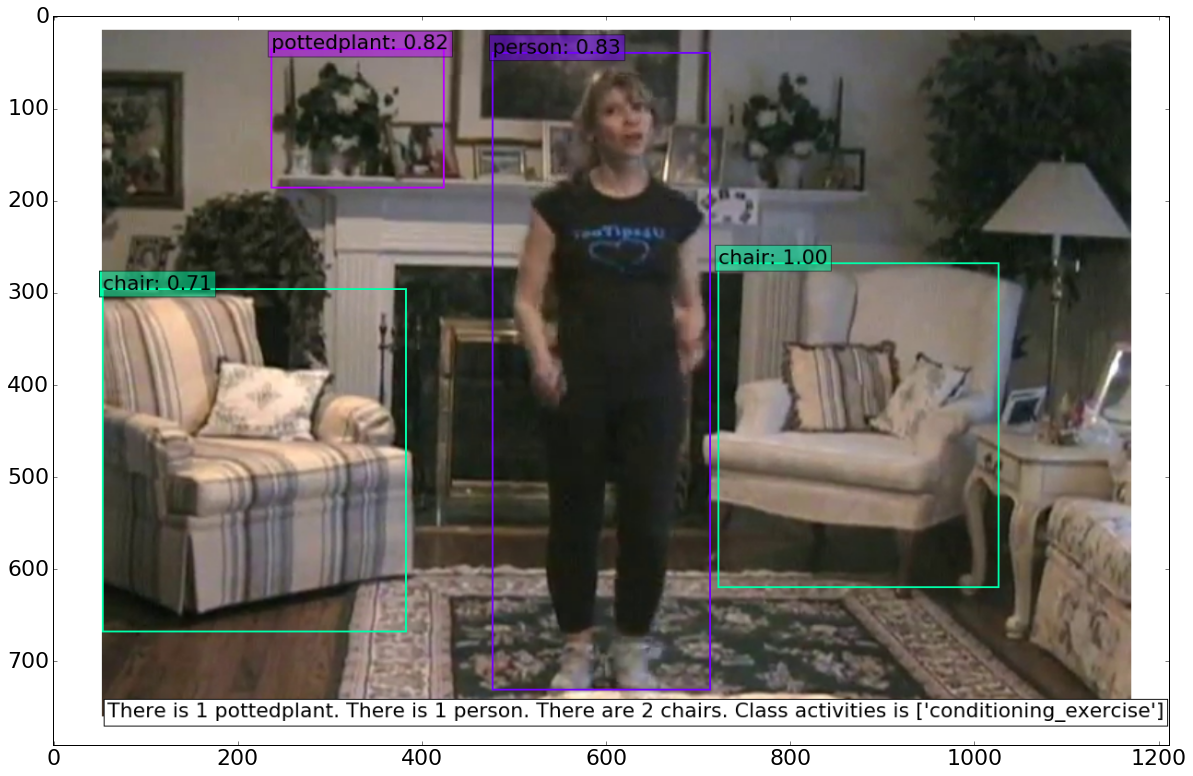

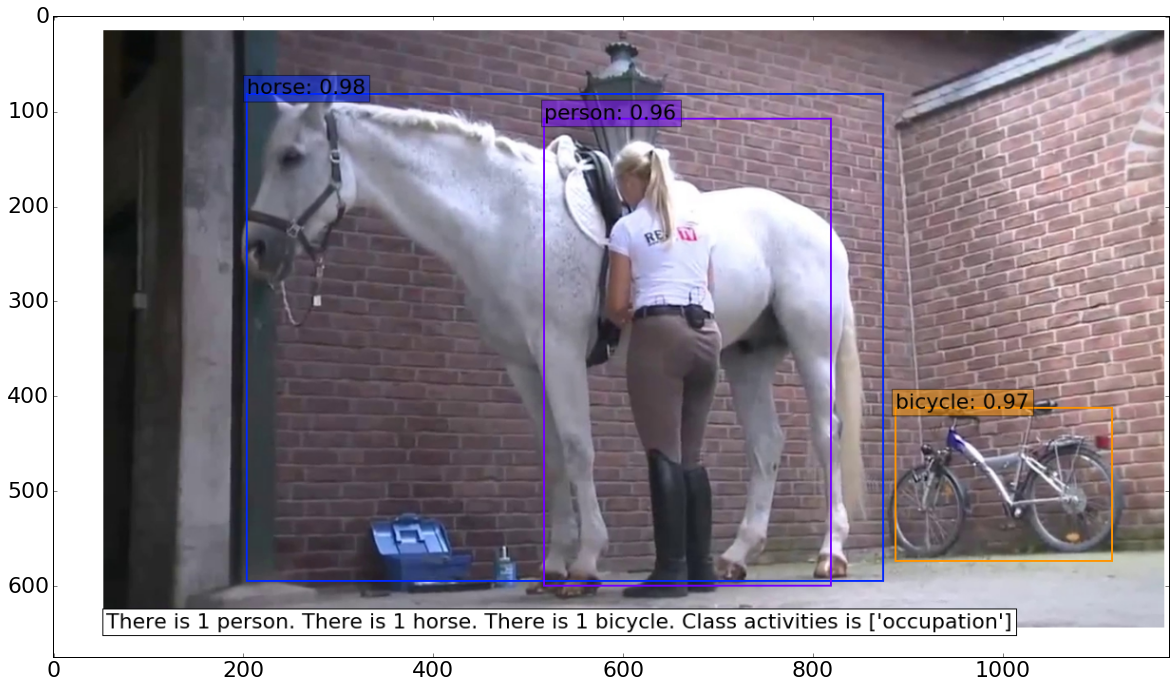